In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata, RBFInterpolator, RegularGridInterpolator
from scipy.stats import norm
import plotly.graph_objects as go

In [ ]:
complete_dataset = pd.read_csv('complete_dataset.csv')

In [ ]:
# bs iv surface first

def build_vol_surface(data, date_col='date', target_date=None, method='rbf'):
    
    # Convert date column
    data[date_col] = pd.to_datetime(data[date_col])
    
    # Select target date
    if target_date is None:
        target_date = data[date_col].max()
    else:
        target_date = pd.to_datetime(target_date)
    
    # Filter data for target date
    day_data = data[data[date_col] == target_date].copy()
    
    if len(day_data) < 5:
        raise ValueError(f"Insufficient data for {target_date}: {len(day_data)} points")
    
    # Prepare coordinates
    X = day_data['time_to_expiry'].values  # Time to expiry
    Y = day_data['moneyness'].values       # Moneyness
    Z = day_data['vol'].values     # Implied volatility
    
    # Remove NaN values
    valid_mask = ~(np.isnan(X) | np.isnan(Y) | np.isnan(Z))
    X, Y, Z = X[valid_mask], Y[valid_mask], Z[valid_mask]
    
    # Remove duplicate points (causes singular matrix in RBF)
    unique_points = {}
    for i in range(len(X)):
        key = (round(X[i], 6), round(Y[i], 6))  # Round to avoid floating point issues
        if key not in unique_points:
            unique_points[key] = (X[i], Y[i], Z[i])
        else:
            # Average volatilities for duplicate points
            existing = unique_points[key]
            unique_points[key] = (existing[0], existing[1], (existing[2] + Z[i]) / 2)
    
    # Convert back to arrays
    X_clean = np.array([pt[0] for pt in unique_points.values()])
    Y_clean = np.array([pt[1] for pt in unique_points.values()])
    Z_clean = np.array([pt[2] for pt in unique_points.values()])
    
    print(f"Cleaned data: {len(X)} -> {len(X_clean)} unique points")
    
    if len(X_clean) < 5:
        raise ValueError(f"Insufficient unique data points: {len(X_clean)}")
    
    # Create interpolation grid
    x_min, x_max = X_clean.min(), X_clean.max()
    y_min, y_max = Y_clean.min(), Y_clean.max()
    
    x_grid = np.linspace(x_min, x_max, 50)
    y_grid = np.linspace(y_min, y_max, 50)
    X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
    
    # Interpolate with error handling
    try:
        if method == 'rbf':
            # Try RBF first
            rbf = RBFInterpolator(
                np.column_stack([X_clean, Y_clean]), Z_clean,
                kernel='thin_plate_spline',
                smoothing=0.1  # Add smoothing to help with numerical stability
            )
            Z_mesh = rbf(np.column_stack([X_mesh.ravel(), Y_mesh.ravel()])).reshape(X_mesh.shape)
            
    except Exception as e:
        print(f"RBF failed ({e}), falling back to linear interpolation")
        method = 'linear'
    
    if method == 'linear':
        # Linear interpolation
        Z_mesh = griddata((X_clean, Y_clean), Z_clean, (X_mesh, Y_mesh), method='linear')
        
    elif method == 'cubic':
        # Cubic interpolation with fallback
        try:
            Z_mesh = griddata((X_clean, Y_clean), Z_clean, (X_mesh, Y_mesh), method='cubic')
        except:
            print("Cubic failed, using linear")
            Z_mesh = griddata((X_clean, Y_clean), Z_clean, (X_mesh, Y_mesh), method='linear')
    
    return {
        'date': target_date,
        'time_grid': x_grid,
        'moneyness_grid': y_grid,
        'time_mesh': X_mesh,
        'moneyness_mesh': Y_mesh,
        'vol_mesh': Z_mesh,
        'raw_data': day_data,
        'method': method,
        'n_points': len(X_clean)
    }

def plot_vol_surface_3d(surface_data, title=None):
    """Plot 3D volatility surface using matplotlib"""
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(
        surface_data['time_mesh'],
        surface_data['moneyness_mesh'], 
        surface_data['vol_mesh'],
        cmap='viridis',
        alpha=0.8
    )
    
    # Add raw data points
    raw_data = surface_data['raw_data']
    ax.scatter(
        raw_data['time_to_expiry'],
        raw_data['moneyness'],
        raw_data['vol'],
        c='red', s=30, alpha=0.8, label='Market Data'
    )
    
    ax.set_xlabel('Time to Expiry (years)')
    ax.set_ylabel('Moneyness (K/S)')
    ax.set_zlabel('Implied Volatility')
    
    if title is None:
        title = f"Volatility Surface - {surface_data['date'].strftime('%Y-%m-%d')}"
    ax.set_title(title)
    
    ax.legend()
    plt.colorbar(surf, shrink=0.5)
    plt.tight_layout()
    plt.show()

def plot_vol_surface_plotly(surface_data, title=None):
    """Plot interactive 3D volatility surface using plotly"""
    
    # Create surface plot
    fig = go.Figure(data=[
        go.Surface(
            x=surface_data['time_mesh'],
            y=surface_data['moneyness_mesh'],
            z=surface_data['vol_mesh'],
            colorscale='Viridis',
            opacity=0.8
        )
    ])
    
    # Add raw data points
    raw_data = surface_data['raw_data']
    fig.add_trace(
        go.Scatter3d(
            x=raw_data['time_to_expiry'],
            y=raw_data['moneyness'],
            z=raw_data['vol'],
            mode='markers',
            marker=dict(size=5, color='red'),
            name='Market Data'
        )
    )
    
    if title is None:
        title = f"Volatility Surface - {surface_data['date'].strftime('%Y-%m-%d')}"
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Time to Expiry (years)',
            yaxis_title='Moneyness (K/S)',
            zaxis_title='Implied Volatility'
        ),
        width=900,
        height=700
    )
    
    fig.show()


def get_vol_from_surface(surface_data, time_to_expiry, moneyness):
    """Get interpolated volatility from surface"""
    
    from scipy.interpolate import interp2d
    
    # Create interpolation function
    # interp_func = interp2d(
    #     surface_data['time_grid'],
    #     surface_data['moneyness_grid'],
    #     surface_data['vol_mesh'],
    #     kind='linear'
    # )

    # return float(interp_func(time_to_expiry, moneyness))
    interp_func = RegularGridInterpolator(
        (surface_data['time_grid'], surface_data['moneyness_grid']),
        surface_data['vol_mesh'].T,  # Transpose to match grid orientation
        method='linear',
        bounds_error=False,
        fill_value=None
    )

    result = interp_func([time_to_expiry, moneyness])
    return float(result[0])

Cleaned data: 96 -> 58 unique points


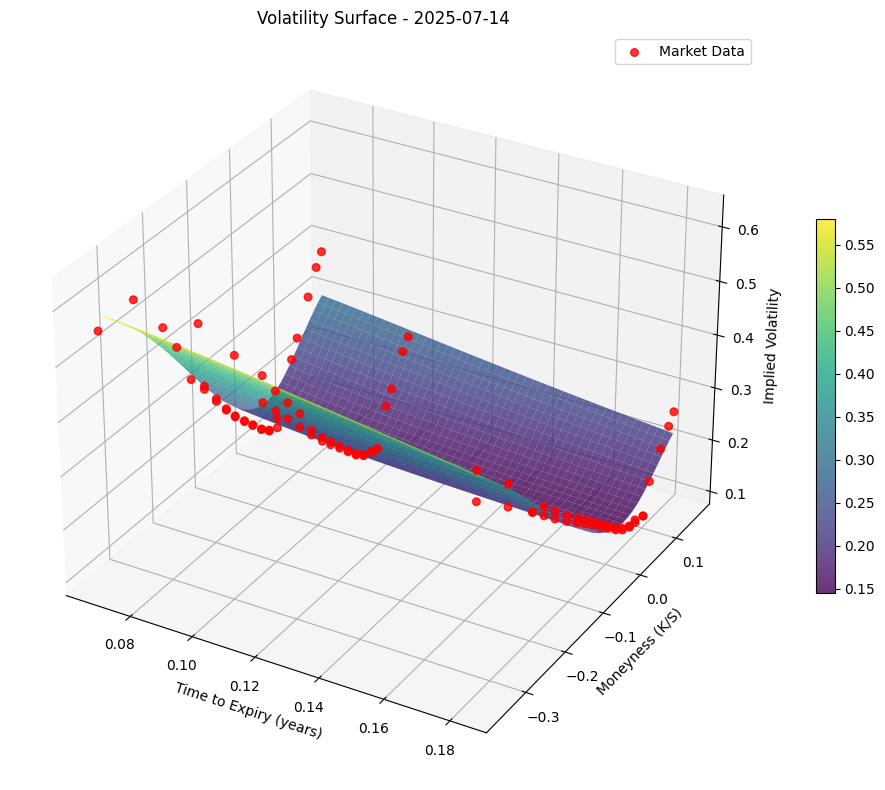

ATM 3-month vol: 61.73%


In [ ]:
surface = build_vol_surface(
    complete_dataset, 
    date_col='date',
    target_date='2025-07-14',  # or None for latest
    method='rbf'
)

plot_vol_surface_3d(surface)

vol = get_vol_from_surface(surface, time_to_expiry=0.25, moneyness=1.0)
print(f"ATM 3-month vol: {vol:.2%}")

In [ ]:
# check your moneyness calculation
print(complete_dataset['moneyness'].describe())
print(f"\nMoneyness range: {complete_dataset['moneyness'].min():.3f} to {complete_dataset['moneyness'].max():.3f}")

if 'log_moneyness' in complete_dataset.columns:
    print(complete_dataset['log_moneyness'].describe())

print(complete_dataset['time_to_expiry'].describe())

Moneyness stats:
count    87808.000000
mean        -0.008724
std          0.144531
min         -0.505338
25%         -0.106632
50%         -0.000447
75%          0.091708
max          0.336348
Name: moneyness, dtype: float64

Moneyness range: -0.505 to 0.336

Time to expiry stats:
count    87808.000000
mean         0.137985
std          0.068895
min          0.043651
25%          0.059524
50%          0.111111
75%          0.202381
max          0.261905
Name: time_to_expiry, dtype: float64


In [11]:
sample = complete_dataset.sample(5)
print("Sample verification:")
for _, row in sample.iterrows():
    calculated_log_moneyness = np.log(row['strike'] / row['spot_price'])
    print(f"Strike: {row['strike']:.0f}, Spot: {row['spot_price']:.2f}")
    print(f"Your moneyness: {row['moneyness']:.4f}, Calculated: {calculated_log_moneyness:.4f}")
    print()

Sample verification:
Strike: 510, Spot: 409.80
Your moneyness: 0.2187, Calculated: 0.2187

Strike: 355, Spot: 273.08
Your moneyness: 0.2624, Calculated: 0.2624

Strike: 205, Spot: 264.49
Your moneyness: -0.2548, Calculated: -0.2548

Strike: 395, Spot: 515.49
Your moneyness: -0.2662, Calculated: -0.2662

Strike: 570, Spot: 604.33
Your moneyness: -0.0585, Calculated: -0.0585



In [12]:
# Check a few interpolated values
print("Sample interpolated volatilities:")
test_points = [
    (0.08, -0.1),   # 1M, ITM put
    (0.08, 0.0),    # 1M, ATM
    (0.08, 0.1),    # 1M, OTM call
    (0.15, 0.0),    # 6M, ATM
]

for t, m in test_points:
    vol = get_vol_from_surface(surface, t, m)
    print(f"T={t:.2f}, M={m:.2f}: Vol={vol:.1%}")

Sample interpolated volatilities:
T=0.08, M=-0.10: Vol=25.9%
T=0.08, M=0.00: Vol=17.3%
T=0.08, M=0.10: Vol=23.3%
T=0.15, M=0.00: Vol=15.1%


***local vol***

Building PROFESSIONAL Local Vol Surface for 2025-07-15
Spot: $627.52, r=4.23%, q=1.21%
Step 1: Building IMPLIED VOLATILITY surface...
Found 98 options for 2025-07-15
Using 98 options after filtering
Strike range: $435 - $810
Expiry range: 0.052 - 0.262 years
IV range: 10.8% - 62.5%
Successfully built IV surface using RBF interpolation
✓ Built IV surface with 98 options

Step 2: Calculating local volatility from IV surface (professional method)...
Calculating local volatility from IV surface (professional method)...
Local volatility range: 5.0% - 100.0%
✓ Surface quality: 30.0% of values in reasonable range (8%-60%)
✓ Local volatility surface calculated successfully!

Step 3: Plotting surfaces...


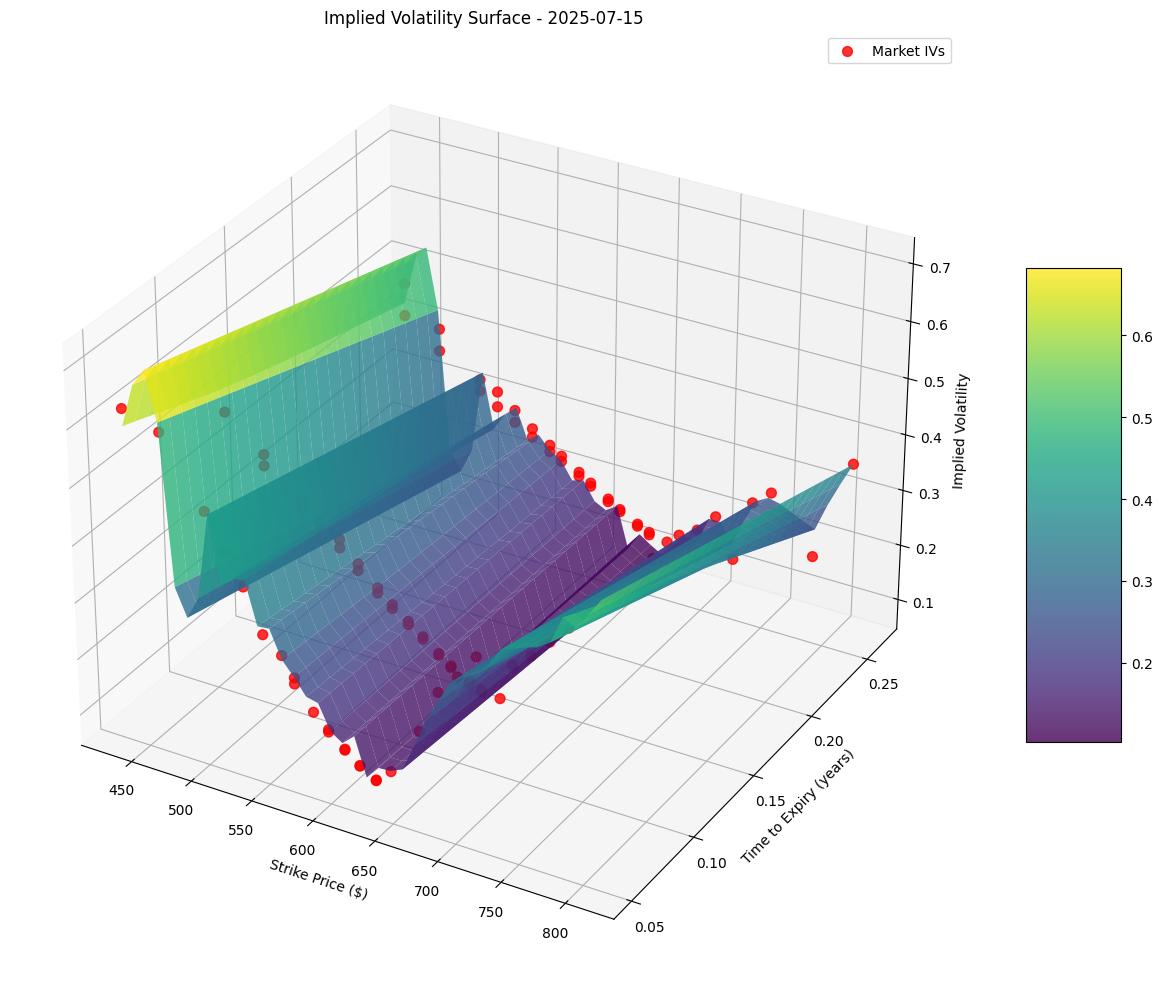

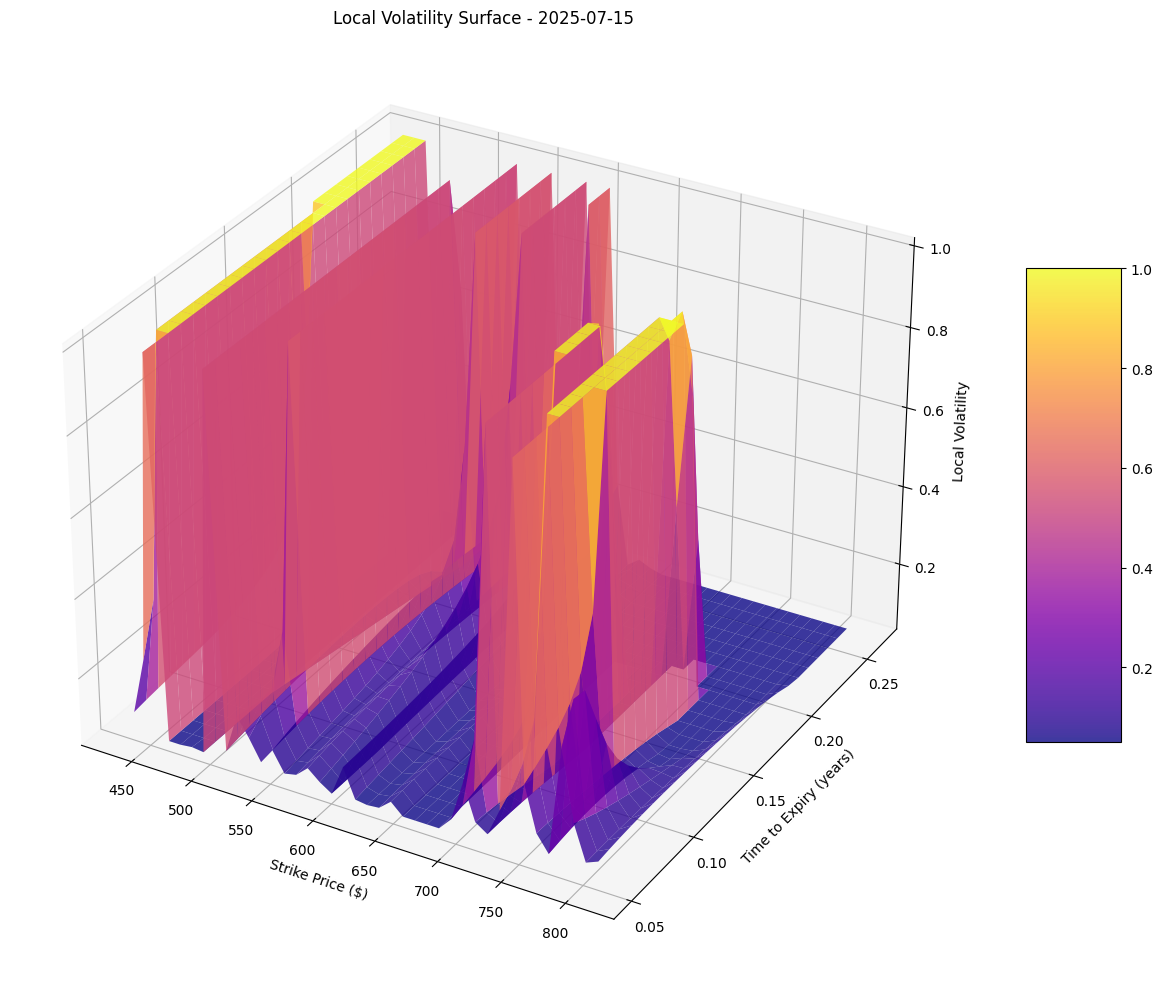

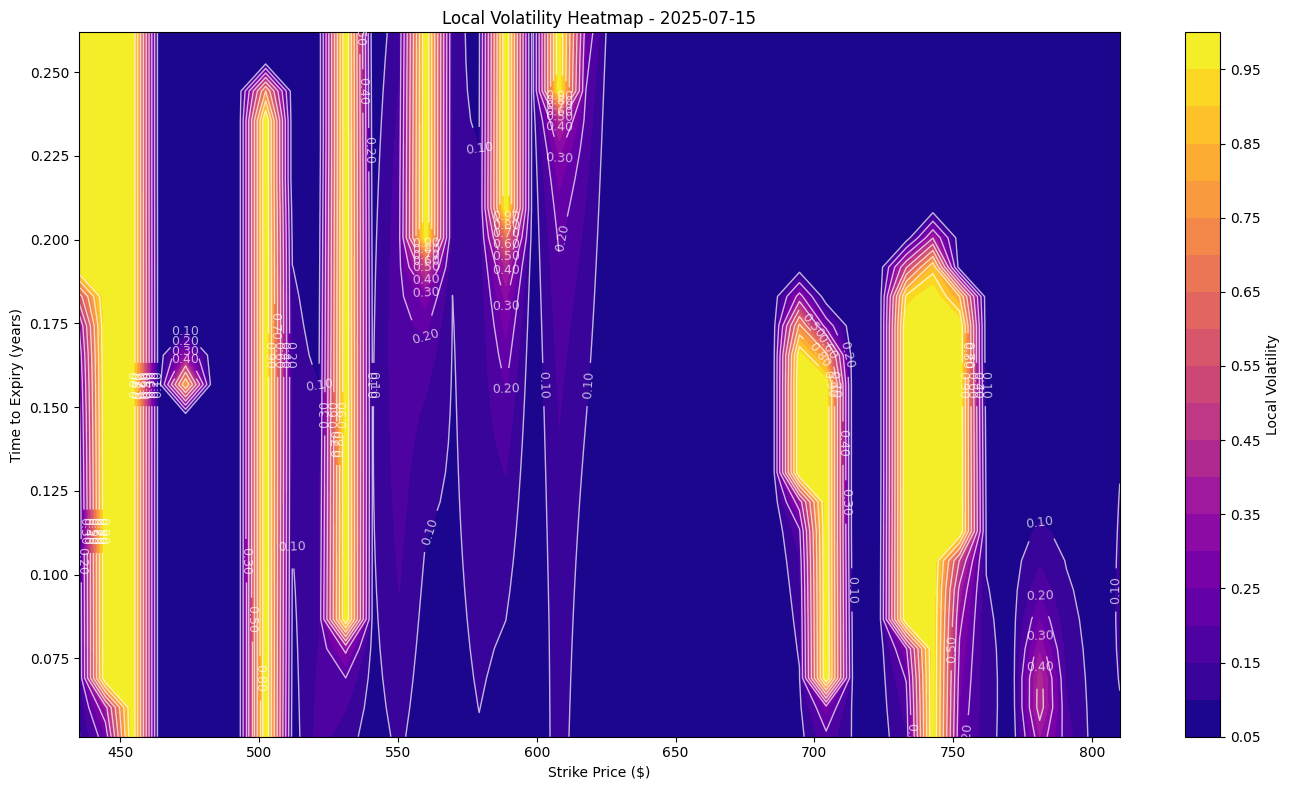

✓ All plots generated successfully!

Step 4: Comparing market IV vs local volatility...

Market IV vs Local Vol Comparison:

Expiry: 0.08 years (29 days)
----------------------------------------
Strike: $565 (M=-0.105)
  Market IV: 25.2%
  Local Vol: 8.1%
  Difference: -17.1%

Strike: $628 (M=0.000)
  Market IV: 12.8%
  Local Vol: 5.0%
  Difference: -7.8%

Strike: $690 (M=0.095)
  Market IV: 30.9%
  Local Vol: 8.1%
  Difference: -22.7%


Expiry: 0.15 years (55 days)
----------------------------------------
Strike: $565 (M=-0.105)
  Market IV: 23.9%
  Local Vol: 12.0%
  Difference: -11.9%

Strike: $628 (M=0.000)
  Market IV: 14.2%
  Local Vol: 5.0%
  Difference: -9.2%

Strike: $690 (M=0.095)
  Market IV: 23.2%
  Local Vol: 57.1%
  Difference: 33.8%


Expiry: 0.25 years (91 days)
----------------------------------------
Strike: $565 (M=-0.105)
  Market IV: 22.8%
  Local Vol: 55.8%
  Difference: 33.0%

Strike: $628 (M=0.000)
  Market IV: 14.8%
  Local Vol: 5.0%
  Difference: -9.7%

Strike

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata, RBFInterpolator, RegularGridInterpolator
from scipy.stats import norm
import plotly.graph_objects as go

class ProfessionalLocalVolSurface:
    def __init__(self, options_data, spot_price, risk_free_rate, dividend_yield):
        self.options_data = options_data
        self.spot_price = spot_price
        self.risk_free_rate = risk_free_rate
        self.dividend_yield = dividend_yield
        self.iv_surface = None
        self.local_vol_surface = None
        
    def black_scholes_call(self, S, K, T, r, q, vol):
        """Black-Scholes call option pricing"""
        if T <= 0 or vol <= 0:
            return max(S - K, 0)
            
        d1 = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
        d2 = d1 - vol*np.sqrt(T)
        
        call_price = S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
        return call_price
    
    def build_iv_surface(self, target_date):
        """
        Build interpolated implied volatility surface from market data
        This is the PROFESSIONAL approach - much more stable than price-based
        """
        # Filter data for target date
        day_data = self.options_data[
            self.options_data['date'] == pd.to_datetime(target_date)
        ].copy()
        
        # Use both calls and puts for better coverage
        options_data = day_data.copy()
        
        if len(options_data) < 10:
            raise ValueError(f"Insufficient options for {target_date}: {len(options_data)} options")
        
        print(f"Found {len(options_data)} options for {target_date}")
        
        # Prepare data - use MARKET IMPLIED VOLATILITIES directly
        strikes = options_data['strike'].values
        expiries = options_data['time_to_expiry'].values
        market_ivs = options_data['vol'].values  # These are already Black-Scholes IVs!
        
        # Filter out extreme IVs for stability
        valid_mask = (market_ivs >= 0.05) & (market_ivs <= 2.0)
        strikes = strikes[valid_mask]
        expiries = expiries[valid_mask]
        market_ivs = market_ivs[valid_mask]
        
        print(f"Using {len(market_ivs)} options after filtering")
        print(f"Strike range: ${strikes.min():.0f} - ${strikes.max():.0f}")
        print(f"Expiry range: {expiries.min():.3f} - {expiries.max():.3f} years")
        print(f"IV range: {market_ivs.min():.1%} - {market_ivs.max():.1%}")
        
        # Create interpolation grid
        strike_min, strike_max = strikes.min(), strikes.max()
        expiry_min, expiry_max = expiries.min(), expiries.max()
        
        # Dense grid for local vol calculation
        strike_grid = np.linspace(strike_min, strike_max, 40)
        expiry_grid = np.linspace(max(expiry_min, 0.02), expiry_max, 25)
        
        K_mesh, T_mesh = np.meshgrid(strike_grid, expiry_grid)
        
        # Interpolate IMPLIED VOLATILITIES (much more stable!)
        try:
            # Use RBF interpolation on IV surface
            points = np.column_stack([strikes, expiries])
            rbf = RBFInterpolator(points, market_ivs, 
                                kernel='thin_plate_spline', 
                                smoothing=0.05)  # Less smoothing needed for IVs
            
            grid_points = np.column_stack([K_mesh.ravel(), T_mesh.ravel()])
            IV_mesh = rbf(grid_points).reshape(K_mesh.shape)
            
            # Apply reasonable bounds to IVs
            IV_mesh = np.clip(IV_mesh, 0.05, 1.5)  # 5% to 150%
            
            print("Successfully built IV surface using RBF interpolation")
            
        except Exception as e:
            print(f"RBF failed: {e}, using linear interpolation")
            IV_mesh = griddata((strikes, expiries), market_ivs, (K_mesh, T_mesh), method='linear')
            
            # Fill NaN values with nearby values
            for i in range(len(expiry_grid)):
                for j in range(len(strike_grid)):
                    if np.isnan(IV_mesh[i, j]):
                        # Use average IV from similar strikes/expiries
                        IV_mesh[i, j] = np.nanmean(market_ivs)
            
            IV_mesh = np.clip(IV_mesh, 0.05, 1.5)
        
        self.iv_surface = {
            'strikes': strike_grid,
            'expiries': expiry_grid,
            'K_mesh': K_mesh,
            'T_mesh': T_mesh,
            'IV_mesh': IV_mesh,
            'raw_data': options_data[valid_mask],
            'date': target_date
        }
        
        return self.iv_surface
    
    def calculate_local_vol_from_iv_surface(self):
        """
        Calculate local volatility from IV surface using the PROFESSIONAL formula:
        
        σ²_LV(K,T) = [σ²_IV + 2σ_IV·T(∂σ_IV/∂T)] / [1 + d₁√T(∂σ_IV/∂K) + ¼(-d₁d₂ + 1/T)(∂σ_IV/∂K)² + σ_IV√T(∂²σ_IV/∂K²)]
        
        This is MUCH more stable than price-based Dupire!
        """
        if self.iv_surface is None:
            raise ValueError("Must build IV surface first")
        
        K_mesh = self.iv_surface['K_mesh']
        T_mesh = self.iv_surface['T_mesh']
        IV_mesh = self.iv_surface['IV_mesh']
        
        print("Calculating local volatility from IV surface (professional method)...")
        
        # Calculate derivatives of IV surface (much more stable than price derivatives!)
        dK = self.iv_surface['strikes'][1] - self.iv_surface['strikes'][0]
        dT = self.iv_surface['expiries'][1] - self.iv_surface['expiries'][0]
        
        # First derivatives
        dIV_dK = np.gradient(IV_mesh, dK, axis=1)
        dIV_dT = np.gradient(IV_mesh, dT, axis=0)
        
        # Second derivative
        d2IV_dK2 = np.gradient(dIV_dK, dK, axis=1)
        
        # Calculate d1 and d2 for each point
        d1 = (np.log(self.spot_price / K_mesh) + 
              (self.risk_free_rate - self.dividend_yield + 0.5 * IV_mesh**2) * T_mesh) / (IV_mesh * np.sqrt(T_mesh))
        d2 = d1 - IV_mesh * np.sqrt(T_mesh)
        
        # Professional local vol formula components
        numerator = (IV_mesh**2 + 2 * IV_mesh * T_mesh * dIV_dT)
        
        denominator = (1 + 
                      d1 * np.sqrt(T_mesh) * K_mesh * dIV_dK + 
                      0.25 * (-d1 * d2 + 1/T_mesh) * (K_mesh * dIV_dK)**2 + 
                      IV_mesh * np.sqrt(T_mesh) * K_mesh**2 * d2IV_dK2)
        
        # Handle numerical stability
        denominator = np.where(denominator <= 0, 0.01, denominator)
        
        # Calculate local variance
        local_variance = numerator / denominator
        
        # Apply sensible bounds
        local_variance = np.clip(local_variance, 0.0025, 1.0)  # 5% to 100% vol
        
        # Convert to local volatility
        local_vol = np.sqrt(local_variance)
        
        print(f"Local volatility range: {local_vol.min():.1%} - {local_vol.max():.1%}")
        
        # Quality check
        reasonable_count = np.sum((local_vol >= 0.08) & (local_vol <= 0.6))
        total_points = local_vol.size
        reasonable_pct = (reasonable_count / total_points) * 100
        
        print(f"✓ Surface quality: {reasonable_pct:.1f}% of values in reasonable range (8%-60%)")
        
        self.local_vol_surface = {
            'strikes': self.iv_surface['strikes'],
            'expiries': self.iv_surface['expiries'],
            'K_mesh': K_mesh,
            'T_mesh': T_mesh,
            'local_vol_mesh': local_vol,
            'date': self.iv_surface['date']
        }
        
        return self.local_vol_surface
    
    def get_local_vol(self, strike, expiry):
        """Get local volatility for specific strike and expiry"""
        if self.local_vol_surface is None:
            raise ValueError("Must calculate local volatility surface first")
        
        # Check bounds
        strike_min, strike_max = self.local_vol_surface['strikes'].min(), self.local_vol_surface['strikes'].max()
        expiry_min, expiry_max = self.local_vol_surface['expiries'].min(), self.local_vol_surface['expiries'].max()
        
        if not (strike_min <= strike <= strike_max and expiry_min <= expiry <= expiry_max):
            return None
        
        # Create interpolator
        interp_func = RegularGridInterpolator(
            (self.local_vol_surface['expiries'], self.local_vol_surface['strikes']),
            self.local_vol_surface['local_vol_mesh'],
            method='linear',
            bounds_error=False,
            fill_value=None
        )
        
        result = interp_func([expiry, strike])
        return float(result[0]) if not np.isnan(result[0]) else None
    
    def plot_iv_surface(self):
        """Plot the implied volatility surface"""
        if self.iv_surface is None:
            raise ValueError("Must build IV surface first")
        
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot IV surface
        surf = ax.plot_surface(
            self.iv_surface['K_mesh'],
            self.iv_surface['T_mesh'],
            self.iv_surface['IV_mesh'],
            cmap='viridis',
            alpha=0.8
        )
        
        # Add raw data points
        raw_data = self.iv_surface['raw_data']
        ax.scatter(
            raw_data['strike'],
            raw_data['time_to_expiry'],
            raw_data['vol'],
            c='red', s=50, alpha=0.8, label='Market IVs'
        )
        
        ax.set_xlabel('Strike Price ($)')
        ax.set_ylabel('Time to Expiry (years)')
        ax.set_zlabel('Implied Volatility')
        ax.set_title(f"Implied Volatility Surface - {self.iv_surface['date']}")
        ax.legend()
        
        plt.colorbar(surf, shrink=0.5, aspect=5)
        plt.tight_layout()
        plt.show()
    
    def plot_local_vol_surface(self):
        """Plot the local volatility surface"""
        if self.local_vol_surface is None:
            raise ValueError("Must calculate local volatility surface first")
        
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot local vol surface
        surf = ax.plot_surface(
            self.local_vol_surface['K_mesh'],
            self.local_vol_surface['T_mesh'],
            self.local_vol_surface['local_vol_mesh'],
            cmap='plasma',
            alpha=0.8
        )
        
        ax.set_xlabel('Strike Price ($)')
        ax.set_ylabel('Time to Expiry (years)')
        ax.set_zlabel('Local Volatility')
        ax.set_title(f"Local Volatility Surface - {self.local_vol_surface['date']}")
        
        plt.colorbar(surf, shrink=0.5, aspect=5)
        plt.tight_layout()
        plt.show()
    
    def plot_local_vol_heatmap(self):
        """Plot local volatility as a heatmap"""
        if self.local_vol_surface is None:
            raise ValueError("Must calculate local volatility surface first")
        
        plt.figure(figsize=(14, 8))
        
        # Create heatmap
        contour_filled = plt.contourf(
            self.local_vol_surface['K_mesh'],
            self.local_vol_surface['T_mesh'],
            self.local_vol_surface['local_vol_mesh'],
            levels=20,
            cmap='plasma'
        )
        
        plt.colorbar(contour_filled, label='Local Volatility')
        plt.xlabel('Strike Price ($)')
        plt.ylabel('Time to Expiry (years)')
        plt.title(f"Local Volatility Heatmap - {self.local_vol_surface['date']}")
        
        # Add contour lines
        contours = plt.contour(
            self.local_vol_surface['K_mesh'],
            self.local_vol_surface['T_mesh'],
            self.local_vol_surface['local_vol_mesh'],
            levels=10,
            colors='white',
            alpha=0.7,
            linewidths=1
        )
        plt.clabel(contours, inline=True, fontsize=9, fmt='%.2f')
        
        plt.tight_layout()
        plt.show()
    
    def compare_iv_vs_local_vol(self):
        """Compare market implied vol vs local vol"""
        if self.local_vol_surface is None:
            raise ValueError("Must calculate local volatility surface first")
        
        print("\nMarket IV vs Local Vol Comparison:")
        print("="*60)
        
        # Sample points for comparison
        strikes = [0.9 * self.spot_price, self.spot_price, 1.1 * self.spot_price]
        expiries = [0.08, 0.15, 0.25]  # 1M, 6M, 3M
        
        for expiry in expiries:
            print(f"\nExpiry: {expiry:.2f} years ({expiry*365:.0f} days)")
            print("-" * 40)
            
            for strike in strikes:
                # Find market IV from raw data
                raw_data = self.iv_surface['raw_data']
                
                # Filter by similar expiry and strike
                similar_options = raw_data[
                    (np.abs(raw_data['time_to_expiry'] - expiry) < 0.03) &
                    (np.abs(raw_data['strike'] - strike) < 30)
                ]
                
                if len(similar_options) > 0:
                    market_iv = similar_options['vol'].mean()
                    moneyness = np.log(strike / self.spot_price)
                    
                    # Get local vol
                    local_vol = self.get_local_vol(strike, expiry)
                    
                    print(f"Strike: ${strike:.0f} (M={moneyness:.3f})")
                    print(f"  Market IV: {market_iv:.1%}")
                    if local_vol:
                        print(f"  Local Vol: {local_vol:.1%}")
                        print(f"  Difference: {(local_vol - market_iv):.1%}")
                    else:
                        print(f"  Local Vol: N/A (outside bounds)")
                    print()

# Main function for professional local volatility
def build_professional_local_vol(complete_dataset, target_date='2025-07-15'):
    """
    Build professional local volatility surface using IV-based method
    """
    
    # Get market parameters for the date
    day_data = complete_dataset[complete_dataset['date'] == pd.to_datetime(target_date)]
    
    if len(day_data) == 0:
        raise ValueError(f"No data for {target_date}")
    
    spot_price = day_data['spot_price'].iloc[0]
    risk_free_rate = day_data['risk_free_rate'].iloc[0]
    dividend_yield = day_data['dividend_yield'].iloc[0]
    
    print(f"Building PROFESSIONAL Local Vol Surface for {target_date}")
    print(f"Spot: ${spot_price:.2f}, r={risk_free_rate:.2%}, q={dividend_yield:.2%}")
    print("=" * 70)
    
    # Create professional local vol surface
    local_vol = ProfessionalLocalVolSurface(
        options_data=complete_dataset,
        spot_price=spot_price,
        risk_free_rate=risk_free_rate,
        dividend_yield=dividend_yield
    )
    
    # Build IV surface (more stable than call price surface)
    print("Step 1: Building IMPLIED VOLATILITY surface...")
    try:
        iv_surface = local_vol.build_iv_surface(target_date)
        print(f"✓ Built IV surface with {len(iv_surface['raw_data'])} options")
    except Exception as e:
        print(f"✗ Error building IV surface: {e}")
        return None
    
    # Calculate local volatility from IV surface
    print("\nStep 2: Calculating local volatility from IV surface (professional method)...")
    try:
        local_vol_surface = local_vol.calculate_local_vol_from_iv_surface()
        print("✓ Local volatility surface calculated successfully!")
    except Exception as e:
        print(f"✗ Error calculating local volatility: {e}")
        return None
    
    # Plot results
    print("\nStep 3: Plotting surfaces...")
    try:
        local_vol.plot_iv_surface()
        local_vol.plot_local_vol_surface()
        local_vol.plot_local_vol_heatmap()
        print("✓ All plots generated successfully!")
    except Exception as e:
        print(f"✗ Error plotting: {e}")
    
    # Compare with market IVs
    print("\nStep 4: Comparing market IV vs local volatility...")
    try:
        local_vol.compare_iv_vs_local_vol()
    except Exception as e:
        print(f"✗ Error in comparison: {e}")
    
    return local_vol

# Test professional local vol values
def test_professional_local_vol(local_vol_model):
    """Test getting specific local vol values"""
    if local_vol_model is None:
        return
        
    print("\n" + "="*70)
    print("PROFESSIONAL LOCAL VOLATILITY VALUES")
    print("="*70)
    
    test_points = [
        (500, 0.08),   # Strike $500, 1 month
        (627, 0.08),   # ATM, 1 month  
        (700, 0.08),   # Strike $700, 1 month
        (580, 0.15),   # ITM, 6 months
        (627, 0.15),   # ATM, 6 months
        (680, 0.15),   # OTM, 6 months
        (627, 0.25),   # ATM, 3 months
    ]
    
    for strike, expiry in test_points:
        local_vol = local_vol_model.get_local_vol(strike, expiry)
        moneyness = np.log(strike / local_vol_model.spot_price)
        
        if local_vol:
            print(f"K=${strike:3.0f}, T={expiry:.2f}Y, M={moneyness:+.3f}: σ_LV = {local_vol:.1%}")
        else:
            print(f"K=${strike:3.0f}, T={expiry:.2f}Y, M={moneyness:+.3f}: σ_LV = N/A")

# Run the complete professional local volatility analysis
if __name__ == "__main__":
    # Build professional local vol surface
    local_vol_model = build_professional_local_vol(complete_dataset, target_date='2025-07-15')
    
    # Test specific values
    test_professional_local_vol(local_vol_model)

In [ ]:


# class StraddleBacktester:
#     """
#     Professional straddle backtesting system with realistic constraints
#     """
    
#     def __init__(self, options_data, transaction_cost_per_contract=2.0, min_vol_edge=0.02):
#         self.options_data = options_data.copy()
#         self.transaction_cost = transaction_cost_per_contract  # $2 per contract realistic
#         self.min_vol_edge = min_vol_edge  # 2% minimum vol difference
#         self.backtest_results = []
#         self.portfolio_value = []
#         self.trades = []
        
#     def black_scholes_call(self, S, K, T, r, vol):
#         """Black-Scholes call price"""
#         if T <= 0:
#             return max(S - K, 0)
        
#         d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
#         d2 = d1 - vol*np.sqrt(T)
        
#         return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    
#     def black_scholes_put(self, S, K, T, r, vol):
#         """Black-Scholes put price"""
#         call_price = self.black_scholes_call(S, K, T, r, vol)
#         return call_price - S + K * np.exp(-r*T)
    
#     def calculate_greeks(self, S, K, T, r, vol, option_type='call'):
#         """Calculate option greeks for risk management"""
#         if T <= 0:
#             return {'delta': 0, 'gamma': 0, 'theta': 0, 'vega': 0}
        
#         d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
#         d2 = d1 - vol*np.sqrt(T)
        
#         if option_type == 'call':
#             delta = norm.cdf(d1)
#         else:  # put
#             delta = norm.cdf(d1) - 1
        
#         gamma = norm.pdf(d1) / (S * vol * np.sqrt(T))
#         theta_call = (-S * norm.pdf(d1) * vol / (2 * np.sqrt(T)) - 
#                      r * K * np.exp(-r*T) * norm.cdf(d2))
#         theta = theta_call if option_type == 'call' else theta_call + r * K * np.exp(-r*T)
#         vega = S * norm.pdf(d1) * np.sqrt(T) / 100  # Per 1% vol change
        
#         return {'delta': delta, 'gamma': gamma, 'theta': theta/365, 'vega': vega}
    
#     def find_straddle_signals(self, robust_local_vol_model, date, min_days_to_expiry=7, max_days_to_expiry=60):
#         """
#         Find straddle trading signals for a specific date
#         """
#         # Get options data for this date
#         day_data = self.options_data[self.options_data['date'] == pd.to_datetime(date)].copy()
        
#         if len(day_data) == 0:
#             return []
        
#         # Get market parameters
#         spot_price = day_data['spot_price'].iloc[0]
#         risk_free_rate = day_data['risk_free_rate'].iloc[0]
        
#         signals = []
        
#         # Group by expiry and strike to find straddles
#         for expiry in day_data['expiration'].unique():
#             expiry_data = day_data[day_data['expiration'] == expiry]
#             days_to_expiry = expiry_data['days_to_expiry'].iloc[0]
#             time_to_expiry = expiry_data['time_to_expiry'].iloc[0]
            
#             # Filter by expiry range
#             if not (min_days_to_expiry <= days_to_expiry <= max_days_to_expiry):
#                 continue
            
#             # Look for ATM and near-ATM strikes
#             strikes = expiry_data['strike'].unique()
#             atm_strikes = strikes[np.abs(strikes - spot_price) <= 50]  # Within $50 of ATM
            
#             for strike in atm_strikes:
#                 # Find call and put at this strike
#                 call_data = expiry_data[
#                     (expiry_data['strike'] == strike) & 
#                     (expiry_data['call_put'] == 'Call')
#                 ]
#                 put_data = expiry_data[
#                     (expiry_data['strike'] == strike) & 
#                     (expiry_data['call_put'] == 'Put')
#                 ]
                
#                 if len(call_data) == 0 or len(put_data) == 0:
#                     continue
                
#                 call_option = call_data.iloc[0]
#                 put_option = put_data.iloc[0]
                
#                 # Check data quality
#                 if (call_option['bid'] <= 0 or put_option['bid'] <= 0 or
#                     call_option['ask'] <= call_option['bid'] or 
#                     put_option['ask'] <= put_option['bid']):
#                     continue
                
#                 # Calculate market prices and IVs
#                 call_market_price = (call_option['bid'] + call_option['ask']) / 2
#                 put_market_price = (put_option['bid'] + put_option['ask']) / 2
#                 straddle_market_price = call_market_price + put_market_price
                
#                 call_market_iv = call_option['vol']
#                 put_market_iv = put_option['vol']
#                 avg_market_iv = (call_market_iv + put_market_iv) / 2
                
#                 # Get local volatility prediction
#                 try:
#                     local_vol = robust_local_vol_model.get_local_vol(strike, time_to_expiry)
#                     if local_vol is None:
#                         continue
#                 except:
#                     continue
                
#                 # Calculate model prices using local vol
#                 model_call_price = self.black_scholes_call(spot_price, strike, time_to_expiry, risk_free_rate, local_vol)
#                 model_put_price = self.black_scholes_put(spot_price, strike, time_to_expiry, risk_free_rate, local_vol)
#                 straddle_model_price = model_call_price + model_put_price
                
#                 # Calculate signal strength
#                 vol_difference = local_vol - avg_market_iv
#                 price_difference = straddle_model_price - straddle_market_price
                
#                 # Generate signal if vol difference is significant
#                 if abs(vol_difference) >= self.min_vol_edge:
                    
#                     # Calculate bid-ask spread cost
#                     call_spread = call_option['ask'] - call_option['bid']
#                     put_spread = put_option['ask'] - put_option['bid']
#                     total_spread_cost = call_spread + put_spread
                    
#                     # Calculate expected profit after transaction costs
#                     if vol_difference > 0:
#                         # Buy straddle (pay ask)
#                         entry_cost = call_option['ask'] + put_option['ask'] + 2 * self.transaction_cost
#                         expected_pnl = straddle_model_price - entry_cost
#                         signal_type = 'BUY_STRADDLE'
#                     else:
#                         # Sell straddle (receive bid)
#                         entry_proceeds = call_option['bid'] + put_option['bid'] - 2 * self.transaction_cost
#                         expected_pnl = entry_proceeds - straddle_model_price
#                         signal_type = 'SELL_STRADDLE'
                    
#                     # Only trade if expected profit > spread costs
#                     if expected_pnl > total_spread_cost:
                        
#                         # Calculate Greeks for risk management
#                         call_greeks = self.calculate_greeks(spot_price, strike, time_to_expiry, risk_free_rate, avg_market_iv, 'call')
#                         put_greeks = self.calculate_greeks(spot_price, strike, time_to_expiry, risk_free_rate, avg_market_iv, 'put')
                        
#                         straddle_greeks = {
#                             'delta': call_greeks['delta'] + put_greeks['delta'],
#                             'gamma': call_greeks['gamma'] + put_greeks['gamma'],
#                             'theta': call_greeks['theta'] + put_greeks['theta'],
#                             'vega': call_greeks['vega'] + put_greeks['vega']
#                         }
                        
#                         signal = {
#                             'date': date,
#                             'expiry': expiry,
#                             'strike': strike,
#                             'spot_price': spot_price,
#                             'days_to_expiry': days_to_expiry,
#                             'time_to_expiry': time_to_expiry,
#                             'signal_type': signal_type,
#                             'market_iv': avg_market_iv,
#                             'local_vol': local_vol,
#                             'vol_difference': vol_difference,
#                             'market_straddle_price': straddle_market_price,
#                             'model_straddle_price': straddle_model_price,
#                             'expected_pnl': expected_pnl,
#                             'total_spread_cost': total_spread_cost,
#                             'call_bid': call_option['bid'],
#                             'call_ask': call_option['ask'],
#                             'put_bid': put_option['bid'],
#                             'put_ask': put_option['ask'],
#                             'greeks': straddle_greeks,
#                             'moneyness': np.log(strike / spot_price)
#                         }
                        
#                         signals.append(signal)
        
#         return signals
    
#     def execute_trade(self, signal, position_size=1):
#         """
#         Execute a straddle trade
#         """
#         if signal['signal_type'] == 'BUY_STRADDLE':
#             entry_cost = (signal['call_ask'] + signal['put_ask'] + 2 * self.transaction_cost) * position_size
#             position_type = 1  # Long straddle
#         else:  # SELL_STRADDLE
#             entry_cost = -(signal['call_bid'] + signal['put_bid'] - 2 * self.transaction_cost) * position_size
#             position_type = -1  # Short straddle
        
#         trade = {
#             'entry_date': signal['date'],
#             'expiry': signal['expiry'],
#             'strike': signal['strike'],
#             'position_type': position_type,  # 1 for long, -1 for short
#             'position_size': position_size,
#             'entry_cost': entry_cost,
#             'entry_spot': signal['spot_price'],
#             'signal_strength': signal['vol_difference'],
#             'expected_pnl': signal['expected_pnl'] * position_size,
#             'greeks': signal['greeks'],
#             'status': 'OPEN'
#         }
        
#         return trade
    
#     def calculate_pnl(self, trade, current_date, current_spot, current_rf_rate):
#         """
#         Calculate current P&L of a straddle position
#         """
#         if trade['status'] == 'CLOSED':
#             return trade.get('realized_pnl', 0)
        
#         # Calculate time to expiry
#         days_left = (pd.to_datetime(trade['expiry']) - pd.to_datetime(current_date)).days
#         time_to_expiry = max(days_left / 365.0, 0)
        
#         if time_to_expiry <= 0:
#             # Option expired - calculate intrinsic value
#             call_intrinsic = max(current_spot - trade['strike'], 0)
#             put_intrinsic = max(trade['strike'] - current_spot, 0)
#             straddle_value = call_intrinsic + put_intrinsic
            
#             # Close the trade
#             trade['status'] = 'EXPIRED'
#             trade['exit_date'] = current_date
#             trade['exit_spot'] = current_spot
            
#         else:
#             # Calculate current option values using market IV (simplified)
#             # In practice, you'd use current market prices
#             estimated_iv = 0.2  # Simplified - use 20% IV
            
#             call_value = self.black_scholes_call(current_spot, trade['strike'], time_to_expiry, current_rf_rate, estimated_iv)
#             put_value = self.black_scholes_put(current_spot, trade['strike'], time_to_expiry, current_rf_rate, estimated_iv)
#             straddle_value = call_value + put_value
        
#         # Calculate P&L
#         if trade['position_type'] == 1:  # Long straddle
#             pnl = (straddle_value * trade['position_size']) - trade['entry_cost']
#         else:  # Short straddle
#             pnl = -trade['entry_cost'] - (straddle_value * trade['position_size'])
        
#         return pnl
    
#     def run_backtest(self, robust_local_vol_model, start_date, end_date, initial_capital=100000, max_position_size=5):
#         """
#         Run complete backtest
#         """
#         print(f"Running Straddle Backtest: {start_date} to {end_date}")
#         print(f"Initial Capital: ${initial_capital:,.0f}")
#         print("=" * 60)
        
#         # Initialize
#         current_capital = initial_capital
#         open_trades = []
#         all_trades = []
#         daily_pnl = []
        
#         # Get unique trading dates
#         trading_dates = sorted(self.options_data['date'].dt.date.unique())
#         trading_dates = [d for d in trading_dates if start_date <= d <= end_date]
        
#         for current_date in trading_dates:
            
#             # Calculate P&L of existing positions
#             total_position_pnl = 0
#             current_spot = self.options_data[self.options_data['date'] == pd.to_datetime(current_date)]['spot_price'].iloc[0]
#             current_rf = self.options_data[self.options_data['date'] == pd.to_datetime(current_date)]['risk_free_rate'].iloc[0]
            
#             for trade in open_trades:
#                 pnl = self.calculate_pnl(trade, current_date, current_spot, current_rf)
#                 total_position_pnl += pnl
                
#                 if trade['status'] in ['EXPIRED', 'CLOSED']:
#                     trade['realized_pnl'] = pnl
#                     all_trades.append(trade)
            
#             # Remove closed trades
#             open_trades = [t for t in open_trades if t['status'] == 'OPEN']
            
#             # Look for new signals
#             try:
#                 signals = self.find_straddle_signals(robust_local_vol_model, current_date)
                
#                 # Execute best signals (limit position count)
#                 if len(open_trades) < max_position_size and len(signals) > 0:
#                     # Sort by expected P&L and take best signal
#                     best_signal = sorted(signals, key=lambda x: x['expected_pnl'], reverse=True)[0]
                    
#                     # Position sizing based on signal strength and available capital
#                     signal_strength = abs(best_signal['vol_difference'])
#                     base_position_size = min(3, int(current_capital / 50000))  # Conservative sizing
#                     position_size = max(1, int(base_position_size * signal_strength / 0.05))
                    
#                     new_trade = self.execute_trade(best_signal, position_size)
#                     open_trades.append(new_trade)
                    
#                     print(f"{current_date}: {new_trade['position_type']:+d} {position_size} straddles @ ${new_trade['strike']:.0f}, Vol Edge: {best_signal['vol_difference']:+.1%}")
            
#             except Exception as e:
#                 # Skip this date if local vol calculation fails
#                 pass
            
#             # Record daily performance
#             current_portfolio_value = current_capital + total_position_pnl
#             daily_pnl.append({
#                 'date': current_date,
#                 'portfolio_value': current_portfolio_value,
#                 'position_pnl': total_position_pnl,
#                 'open_positions': len(open_trades),
#                 'spot_price': current_spot
#             })
        
#         # Close any remaining open trades at final date
#         for trade in open_trades:
#             final_pnl = self.calculate_pnl(trade, trading_dates[-1], current_spot, current_rf)
#             trade['realized_pnl'] = final_pnl
#             trade['status'] = 'CLOSED'
#             all_trades.append(trade)
        
#         # Store results
#         self.backtest_results = pd.DataFrame(daily_pnl)
#         self.trades = pd.DataFrame(all_trades)
        
#         return self.analyze_results()
    
#     def analyze_results(self):
#         """
#         Analyze backtest performance
#         """
#         if len(self.trades) == 0:
#             print("No trades executed in backtest")
#             return None
        
#         results = self.backtest_results
#         trades = self.trades
        
#         # Calculate metrics
#         total_trades = len(trades)
#         winning_trades = len(trades[trades['realized_pnl'] > 0])
#         win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
#         total_pnl = trades['realized_pnl'].sum()
#         avg_win = trades[trades['realized_pnl'] > 0]['realized_pnl'].mean() if winning_trades > 0 else 0
#         avg_loss = trades[trades['realized_pnl'] < 0]['realized_pnl'].mean() if (total_trades - winning_trades) > 0 else 0
        
#         initial_value = results['portfolio_value'].iloc[0]
#         final_value = results['portfolio_value'].iloc[-1]
#         total_return = (final_value - initial_value) / initial_value
        
#         # Calculate Sharpe ratio (simplified)
#         daily_returns = results['portfolio_value'].pct_change().dropna()
#         sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if len(daily_returns) > 1 else 0
        
#         # Max drawdown
#         running_max = results['portfolio_value'].expanding().max()
#         drawdown = (results['portfolio_value'] - running_max) / running_max
#         max_drawdown = drawdown.min()
        
#         summary = {
#             'Total Trades': total_trades,
#             'Win Rate': f"{win_rate:.1%}",
#             'Total P&L': f"${total_pnl:,.0f}",
#             'Total Return': f"{total_return:.1%}",
#             'Average Win': f"${avg_win:.0f}",
#             'Average Loss': f"${avg_loss:.0f}",
#             'Sharpe Ratio': f"{sharpe_ratio:.2f}",
#             'Max Drawdown': f"{max_drawdown:.1%}",
#             'Final Portfolio Value': f"${final_value:,.0f}"
#         }
        
#         # Print summary
#         print("\nBACKTEST RESULTS")
#         print("=" * 50)
#         for key, value in summary.items():
#             print(f"{key:.<25} {value}")
        
#         return summary
    
#     def plot_results(self):
#         """
#         Plot backtest results
#         """
#         if len(self.backtest_results) == 0:
#             return
        
#         fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
#         results = self.backtest_results
        
#         # 1. Portfolio value over time
#         ax1.plot(pd.to_datetime(results['date']), results['portfolio_value'], linewidth=2)
#         ax1.set_title('Portfolio Value Over Time')
#         ax1.set_ylabel('Portfolio Value ($)')
#         ax1.grid(True, alpha=0.3)
        
#         # 2. Position P&L over time
#         ax2.plot(pd.to_datetime(results['date']), results['position_pnl'], color='green', alpha=0.7)
#         ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
#         ax2.set_title('Position P&L Over Time')
#         ax2.set_ylabel('Position P&L ($)')
#         ax2.grid(True, alpha=0.3)
        
#         # 3. Number of open positions
#         ax3.plot(pd.to_datetime(results['date']), results['open_positions'], color='orange')
#         ax3.set_title('Number of Open Positions')
#         ax3.set_ylabel('Open Positions')
#         ax3.grid(True, alpha=0.3)
        
#         # 4. Trade P&L distribution
#         if len(self.trades) > 0:
#             ax4.hist(self.trades['realized_pnl'], bins=20, alpha=0.7, edgecolor='black')
#             ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7)
#             ax4.set_title('Trade P&L Distribution')
#             ax4.set_xlabel('Realized P&L ($)')
#             ax4.set_ylabel('Frequency')
#             ax4.grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         plt.show()

# # Example usage
# def run_straddle_backtest(complete_dataset, robust_local_vol_model):
#     """
#     Run complete straddle backtest
#     """
    
#     # Create backtester
#     backtester = StraddleBacktester(
#         options_data=complete_dataset,
#         transaction_cost_per_contract=2.0,  # $2 per contract
#         min_vol_edge=0.02  # 2% minimum vol difference
#     )
    
#     # Run backtest on available data
#     start_date = complete_dataset['date'].min().date()
#     end_date = complete_dataset['date'].max().date()
    
#     print(f"Available data: {start_date} to {end_date}")
    
#     # Run backtest
#     summary = backtester.run_backtest(
#         robust_local_vol_model=robust_local_vol_model,
#         start_date=start_date,
#         end_date=end_date,
#         initial_capital=100000,
#         max_position_size=5
#     )
    
#     # Plot results
#     backtester.plot_results()
    
#     return backtester, summary


🚀 Straddle Backtesting System Ready!
Usage: backtester, summary = run_straddle_backtest(complete_dataset, robust_model)


Available data: 2019-05-10 to 2025-07-15
Running Straddle Backtest: 2019-05-10 to 2025-07-15
Initial Capital: $100,000
2021-07-28: +1 4 straddles @ $465, Vol Edge: +11.8%
2021-08-04: +1 4 straddles @ $465, Vol Edge: +11.4%
2021-08-16: +1 9 straddles @ $465, Vol Edge: +24.9%
2021-08-18: +1 3 straddles @ $466, Vol Edge: +9.9%
2021-08-23: +1 4 straddles @ $465, Vol Edge: +12.3%
2021-09-15: +1 9 straddles @ $466, Vol Edge: +23.7%
2021-09-27: +1 4 straddles @ $469, Vol Edge: +11.1%
2021-10-18: +1 9 straddles @ $465, Vol Edge: +24.1%
2021-10-20: +1 8 straddles @ $471, Vol Edge: +21.8%
2021-10-22: +1 8 straddles @ $471, Vol Edge: +22.1%
2021-10-25: +1 9 straddles @ $465, Vol Edge: +24.1%
2021-11-15: +1 12 straddles @ $467, Vol Edge: +31.3%
2021-11-24: +1 11 straddles @ $479, Vol Edge: +28.7%
2021-11-29: +1 10 straddles @ $474, Vol Edge: +27.2%
2021-12-01: +1 9 straddles @ $469, Vol Edge: +23.4%
2021-12-03: +1 8 straddles @ $472, Vol Edge: +22.2%
2021-12-08: +1 10 straddles @ $478, Vol Edge: +

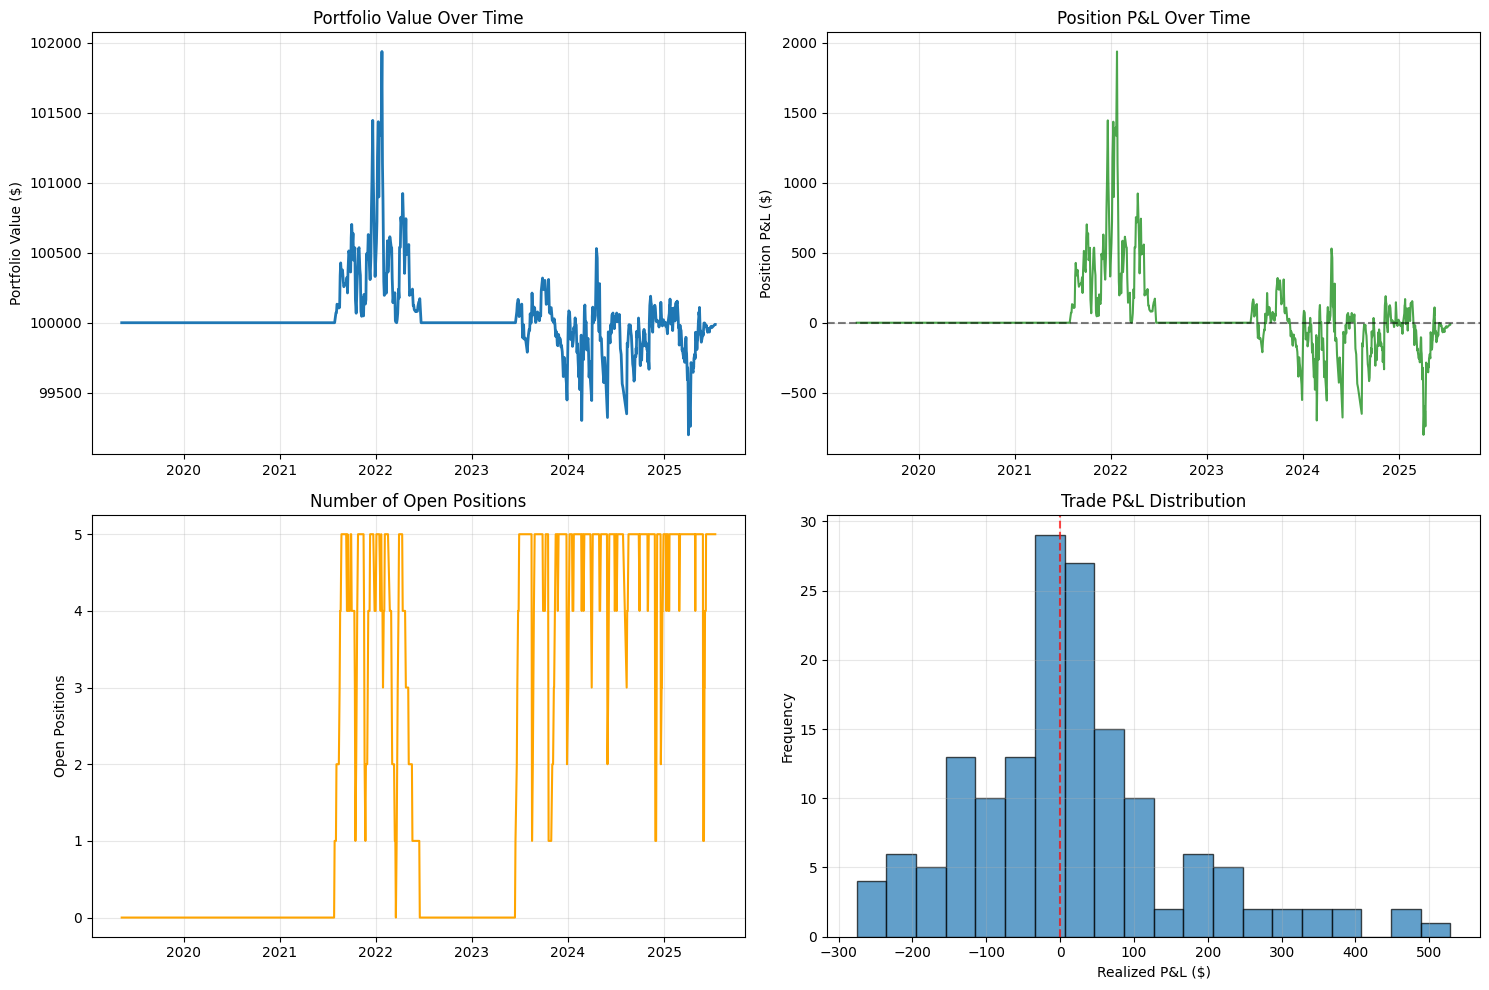

In [ ]:
# # Execute the straddle backtest
# backtester, summary = run_straddle_backtest(complete_dataset, robust_model)